extraccion de segmentos para generar listas de compatibilidades e incompatibilidades


In [1]:
#Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage import io
from scipy.cluster.hierarchy import linkage, fcluster


from ipynb.fs.full.bordes import genera_bordes
from ipynb.fs.full.Megapixels import reordenar

#Imports tests

from ipynb.fs.full.Tests import test_BR
from ipynb.fs.full.Tests import ASA

#imports extraccion caracteristicas

from ipynb.fs.full.caracteristicas import caractRGB
from ipynb.fs.full.caracteristicas import caractRGB2
from ipynb.fs.full.caracteristicas import caractHSV
from ipynb.fs.full.caracteristicas import caractHSV2
from ipynb.fs.full.caracteristicas import caractHSV3
from ipynb.fs.full.caracteristicas import caractXYZ
from ipynb.fs.full.caracteristicas import caractXYZ2




In [2]:
#Leo la imagen
directorio="compartir"
nombre_imagen="bordes_mejorados.npy"
nombre_segmentacion="n_segments_bordes2.npy"
nombre_segmentacion2="segments_FSL_bordes2.npy"

imagen=np.load(os.path.join(directorio,nombre_imagen))

segmentacion=np.load(os.path.join(directorio,nombre_segmentacion))
segmentacionFSL=np.load(os.path.join(directorio,nombre_segmentacion2))

bordes_mejorados=np.load(os.path.join(directorio,"bordes_mejorados.npy"))
bordes_separados=np.load(os.path.join(directorio,"bordes_separados.npy"))

In [3]:
#leemos la imagen inicial y los bordes reales
directorio="compartir"
nombre_imagen="imagen_org.jpg"
nombre_bordes="bordes_image_G_S.npy"
nombre_segmentacion="image_G_S.npy"

imagen_org = cv2.imread(os.path.join(directorio,nombre_imagen))
imagen_org=cv2.cvtColor(imagen_org, cv2.COLOR_BGR2RGB)
bordes_image_G_S=np.load(os.path.join(directorio,nombre_bordes))
image_G_S=np.load(os.path.join(directorio,nombre_segmentacion))

#leemos la imagen con la que trabajamos

foto=np.load(os.path.join(directorio,"foto.npy"))
foto=str(foto)

# DATOS

In [4]:
# variedad="Todos"

In [5]:
# vemos si hacemos con segmentacion todos (segmentacion) o FSL (segmentacion 2)

segmentacion=segmentacionFSL
variedad="FSL"

In [6]:
#caracterizamos los superpixels
car_spixel,_=caractXYZ(segmentacion,imagen_org)

#Tipo caracterizacion

# car="RGB"
# car="RGB2"
car="XYZ"
# car="HSV"
# car="HSV2"
# car="HSV3"



D:\Users\Roberto\Datos\TFM\caracteristicas.ipynb:191: RuntimeWarning: Mean of empty slice.
  "    imagen_hsv=imagen3\n",
D:\Users\Roberto\Anaconda\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Users\Roberto\Anaconda\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Users\Roberto\Anaconda\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
D:\Users\Roberto\Anaconda\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
n_max_clusters=100 #maximo de clusters que queremos
n_min_clusters=2 #minimo de clusters que queremos
dist=[0,0.2,1] #proporcion de distancia por la que queremos cortar el arbol (inicial, por pareto y min y max)
clusters=np.array([0])

while clusters.max()>n_max_clusters or clusters.max()<n_min_clusters:
    
    # Calcular las distancias utilizando el método de enlace
    enlace = linkage(car_spixel, method='average')
    #enlace = linkage(car_spixel, method='single',metric="chebyshev")


    # Especificar la proporción de la distancia máxima
    proporcion_distancia_max = dist[1]

    # Obtener la clusterización en función de la proporción de la distancia máxima
    clusters = fcluster(enlace, proporcion_distancia_max * enlace[:, 2].max(), criterion='distance')
    
    if clusters.max()<n_min_clusters:
#         print("+ antes de recalcular:",dist, "(clusters ",clusters.max(),")")
        dist[2]=dist[1]
        dist[1]=((dist[1]-dist[0])/2)+dist[0]
#         print("+ despues de recalcular:",dist,"(clusters ",clusters.max(),")")
    elif clusters.max()>n_max_clusters:
#         print("- antes de recalcular:", dist,"(clusters ",clusters.max(),")")
        dist[0]=dist[1]
        dist[1]=((dist[2]-dist[1])/2)+dist[1]
#         print("- despues de recalcular:",dist,"(clusters ",clusters.max(),")")
    

# print(clusters.max(),clusters.min(),clusters)


In [8]:
#meto la imagen que he realizado en prueba mejorar bordes
imagen_binarizada=bordes_mejorados

print("tipo bordes mejorados:",bordes_mejorados.dtype)

tipo bordes mejorados: uint8


In [9]:
#separamos un contorno para ver que se hace bien
bordes_1=(np.where(bordes_separados==1,255,0)).astype(np.uint8)
print("tipo de bordes1: ",bordes_1.dtype)

tipo de bordes1:  uint8


In [10]:
contornos=[[]]
for elem in np.unique(bordes_separados):
    
#     print(elem)
    if elem==0: contornos[0]=0
    if elem>0:
        borde=(np.where(bordes_separados==elem,255,0)).astype(np.uint8)
        
        # Encuentra contornos en la imagen binarizada
        aux_contornos, _ = cv2.findContours(borde, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if elem==1: 
            contornos[0]=aux_contornos
        else:
            contornos.append(aux_contornos)



        # Dibuja los contornos en una imagen en blanco
        imagen_contornos = np.zeros((borde.shape))
        #print(np.unique(bordes_1),bordes_1.dtype,bordes_1.shape)
        #print(np.unique(bordes_1),bordes_1.dtype,bordes_1.shape)
        for contorno in aux_contornos:
            cv2.drawContours(imagen_contornos, [contorno], 0, (255), 1)

        # Muestra las imágenes original, en escala de grises, binarizada y con contornos

#         plt.figure(figsize=(20, 20))
#         plt.subplot(1,2,1)
#         plt.title('Imagen Original')
#         plt.imshow(imagen, cmap="grey")
#         plt.axis('off')

#         plt.subplot(1,2,2)
#         plt.title('Imagen ?')
#         plt.imshow(borde, cmap="grey")
#         plt.axis('off')
        #print("contornos[",elem-1,"] - valor: ",contornos[elem-1])
        #print("tamaño contornos:",len(contornos[0]))




#print(contornos)

In [11]:
#tamaño mínimo para no hacerlo mas ancho
cont_min=5

#prueba contornos minimo rectangulo
a_unir=[]
a_area=[]
# Muestra los recortes de los contornos
for elem in np.unique(bordes_separados):
    i=elem
    a_unir.append([])
    a_area.append([])
#     print("Nº contorno:",elem)
    if elem==0: pass
    if elem>0:
        
        borde=(np.where(bordes_separados==elem,255,0)).astype(np.uint8)
        
        # Encuentra contornos en la imagen binarizada
        cont, _ = cv2.findContours(borde, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Crea una máscara en blanco
        mascara = np.zeros_like(imagen_binarizada)

        # Encuentra el rectángulo mínimo
        rect = cv2.minAreaRect(cont[0])

        if rect[1][0]<=cont_min:
            #print("Angulo: ",rect[2])
            rect1=((rect[0][0],rect[0][1]),(rect[1][0]+3,rect[1][1]),rect[2])
            #print("Hemos cambiado el valor, antes:",rect,"despues: ",rect1)
            del rect
            rect=rect1

        if rect[1][1]<=cont_min:
            #print("Angulo: ",rect[2])
            rect1=((rect[0][0],rect[0][1]),(rect[1][0],rect[1][1]+3),rect[2])
            #print("Hemos cambiado el valor, antes:",rect,"despues: ",rect1)
            del rect
            rect=rect1


        # Convierte las coordenadas del rectángulo a enteros
        box = np.int0(cv2.boxPoints(rect))
        #print(rect, "area", cv2.contourArea(contorno))
        #print(box)

        # Dibuja el contorno actual en la máscara
        cv2.drawContours(mascara, [box], 0, (255), thickness=cv2.FILLED)


        #print(mascara.shape,np.unique(mascara),bordes_separados.shape,np.unique(bordes_separados))
        # Realiza el recorte utilizando la máscara
        recorte = cv2.bitwise_xor(mascara, borde, mask=mascara)

        # Realizo un recorte auxiliar para mejorar los contornos

        recorte_aux=cv2.bitwise_and(mascara,borde, mask=mascara)
        kernel3 = np.ones((3,3), np.uint8)
        kernel5=np.ones((7,7),np.uint8)
        recorte_aux = cv2.dilate(recorte_aux, kernel3, iterations=1)

        #recorte_aux = cv2.bitwise_xor(recorte_aux, imagen_binarizada, mask=mascara)
        recorte=cv2.bitwise_xor(mascara,recorte_aux, mask=mascara)
        
        borde_extra=cv2.dilate(borde, kernel5, iterations=1)
        
        solo_borde=cv2.bitwise_and(recorte,borde_extra)
        
#         plt.figure(figsize=(10, 10))
#         plt.imshow(solo_borde[25:75,50:150], cmap='gray')
#         plt.title(f'Solo contorno {i + 1}')


        if i>=0 :    

    #         # Muestra mascara
    #         plt.imshow(mascara, cmap='gray')
    #         plt.title(f'Mascara {i + 1}')
    #         plt.show()

    #         plt.imshow(recorte_aux, cmap='gray')
    #         plt.title(f'recorte aux {i + 1}')
    #         plt.show()

    #         plt.imshow(a, cmap='gray')
    #         plt.title(f'a {i + 1}')
    #         plt.show()


            x,y,w,l=cv2.boundingRect(cont[0])

            # Muestra el recorte
#             plt.figure(figsize=(15, 15))
#             plt.subplot(1,2, 1)
#             plt.imshow(solo_borde, cmap='gray')
#             plt.title(f'Recorte Contorno {i + 1}')


#             plt.subplot(1,2, 2)
#             plt.imshow(recorte_aux[y:y+l,x:x+w], cmap='gray')
#             plt.title(f'Recorte Contorno visual {i + 1}')
#             plt.show()

            subcontornos, _ = cv2.findContours(solo_borde, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            a_unir[i].append([])
            a_area[i].append([])
            for j, subcontorno in enumerate(subcontornos):


                # Crea una máscara en blanco
                mascara2 = np.zeros_like(recorte)

                # Encuentra el rectángulo mínimo
                rect = cv2.minAreaRect(subcontorno)
                #print(rect, "area: ", cv2.contourArea(subcontorno))

                # Convierte las coordenadas del rectángulo a enteros
                box = np.int0(cv2.boxPoints(rect))

                # Dibuja el contorno actual en la máscara
                cv2.drawContours(mascara2, [subcontorno], 0, (255), thickness=cv2.FILLED)

                # Realiza el recorte utilizando la máscara
                recorte2 = cv2.bitwise_and(mascara2, recorte, mask=mascara2)


                x,y,w,l=cv2.boundingRect(subcontorno)

                # calculo area del subcontorno en pixeles
                area_subc=np.sum(recorte2/255).astype(int)
#                 print ("Area del subcontorno: ",area_subc)


                # Muestra el recorte
#                 plt.figure(figsize=(15, 15))
#                 plt.subplot(1,3, 1)
#                 plt.imshow(recorte2, cmap='gray')
#                 plt.title(f'Recorte Subcontorno {j + 1}, de contorno {i+1}')


#                 plt.subplot(1,3, 2)
#                 plt.imshow(recorte2[y:y+l,x:x+w], cmap='gray')
#                 plt.title(f'Recorte Subcontorno {j + 1}, de contorno {i+1}')

    #             print(imagen_binarizada.shape,segmentacion.shape,recorte.shape)
    #             print("segmentacion:",y,"-",y+l,"---",x,x+w,"forma:",segmentacion[y:y+l,x:x+w].shape,segmentacion[y:y+l,x:x+w])
    #             print(segmentacion[y,x],segmentacion[y+l,x+w])
    #             print("recorte:",y,"-",y+l,"---",x,x+w,"forma: ",recorte2[y:y+l,x:x+w].shape,recorte2[y:y+l,x:x+w])

#                 plt.subplot(1,3,3 )
#                 plt.imshow(segmentacion[y:y+l,x:x+w]*(recorte2[y:y+l,x:x+w]/255), cmap='gray')
#                 plt.title(f'segmentos')

                plt.show()
                a=int(i)
                b=int(j)
                if j==0:
                    a_unir[i][0]=(np.unique(segmentacion[y:y+l,x:x+w]*(recorte2[y:y+l,x:x+w]/255)).astype(int))
                    a_area[i][0]=area_subc
                else:    
                    a_unir[i].append(np.unique(segmentacion[y:y+l,x:x+w]*(recorte2[y:y+l,x:x+w]/255)).astype(int))
                    a_area[i].append(area_subc)

#                 print("segmentos a unir:",a_unir)
#                 print("areas:",a_area)



    

C:\Users\Roberto\AppData\Local\Temp\ipykernel_8868\679401192.py:43: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(rect))
C:\Users\Roberto\AppData\Local\Temp\ipykernel_8868\679401192.py:130: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(rect))


In [12]:
np.max(segmentacion)

200

In [13]:
display(a_unir[0])

[]

In [14]:
#funcion sustituir valores

def sustituye (valor, valores, matriz):
    """sustituye los valores dados por el valor introducido en la matriz"""
    condicion=np.isin(matriz,valores)
    matriz2=np.where(condicion,valor,matriz)
#     print("he cambiado")
    return matriz2
   

In [15]:
#funcion sustituir valores

def sustituye_mas (valores, matriz,clusters):
    """sustituye los valores dados por el número siguiente del valor máximo de la matriz"""
    lista=[]
    valores=valores
#     print(valores)
    for elem in range(len(valores)):
        if clusters[valores[0]]!=clusters[valores[elem]]:
            lista.append(elem)
#             print("el grupo es: ",clusters[valores[elem]])
#             print("el elemento:",valores[elem], "es del grupo: ",clusters[valores[elem]])
#             print("vamos a eliminar: ",valores[elem])
    valores=np.delete(valores,lista)
    condicion=np.isin(matriz,valores)
#     matriz2=np.where(condicion,np.max(matriz)+1,matriz)
#     print("he cambiado:",valores,"por:",np.max(matriz)+1)
    matriz2=np.where(condicion,valores[0],matriz)
#     print("he cambiado:",valores,"por:",valores[0])
    return matriz2, valores[0],valores

In [16]:
#funcion cambiar valores en el listado de cambios

def cambia (valor, valores, lista):
    """sustituye los valores dados por el valor introducido en la lista"""
    
    valores=list(valores)
#     print("valor:",valor," tipo:",type(valor))
#     print("valores:",valores," tipo:",type(valores))
#     print("valor:",len(lista)," tipo:",type(lista))
    
    for i, fila in enumerate(lista):
        
        for j, datos in enumerate(fila):
            datos=list(datos.astype(int))
            #print("datos:",datos," tipo:",type(datos))            
            c1=set(valores)
            c2=set(datos)
#             print("contorno:",i+1,"subcontorno:",j+1)
#             print("Se encuentran: ",valores, "en ",datos, "-",len(c1.intersection(c2)))
#             print("longitud de los datos: ",len(datos))
            if len(c1.intersection(c2))>0 and len(datos)>=3:
                    # Verificar si el valor está en el vector a reemplazar
#                     print("si se encuentran")
                    for k in range(len(datos)):
                        if datos[k] in valores:
                            # Reemplazar el valor con el nuevo valor
#                             print("reemplazo :",datos[k])
                            lista[i][j][k] = valor
    return lista

In [17]:
def sustituye_cont (valor, valores, lista):
    """sustituye los valores por valor en una lista de listas"""
    
    for i in range(len(lista)):
#         print(i,"lista ", lista[i])
        for elem in range(len(lista[i])):
#             print("elemento ",lista[i][elem])
            for item in range(len(lista[i][elem])):
#                 print("item",lista[i][elem][item])
                if lista[i][elem][item] in valores: lista[i][elem][item]=valor
#                 print("item despues",lista[i][elem][item])
#             print("elemento despues ",lista[i][elem])
    
    return lista
    

In [18]:
# np.unique(segmentacion)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [19]:
#tamaño mínimo para considerar unir
subcont_min=16

#unir las que pertenecen a un mismo subcontorno
segmentacion1=segmentacion
for i, cont in enumerate(a_unir):
    for j, subcont in enumerate(cont):
#         print("len del subcontorno:",i,"-",j,"es:",len(subcont))
#         if j==4:print("SUBCONTORNO:",subcont)
        if len(subcont)<3:
#             print("el subcontorno: ",subcont, "tiene pocos elementos.")
            pass
        else:
#             print("area:",a_area[i][j])
            if a_area[i][j]>subcont_min:
#                 print("elementos subcontorno:", i,",",j,"-",subcont)
#                 print("sustituyo los elementos: ",subcont[2:], "por: ",subcont[1])
                #segmentacion1=sustituye(subcont[1],subcont[2:],segmentacion1)
                segmentacion1,val_sust,vals_sust=sustituye_mas(subcont[1:],segmentacion1,clusters)
#                 print(type(a_unir))
                #a_unir=cambia(subcont[1].astype(int),subcont[2:].astype(int),a_unir)
#                 print("nuevos elementos: ",a_unir[i][j])
                a_unir=sustituye_cont(val_sust, vals_sust, a_unir)
                #print(np.unique(segmentacion1))
#             else: print("NADA, pequeño")
            
        


In [20]:
# np.unique(segmentacion)
   

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [21]:
# np.unique(segmentacion1)


array([  1,   2,   3,   4,   5,   6,   8,   9,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  52,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  77,  78,  79,  80,  81,  83,  84,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       102, 103, 104, 105, 106, 108, 109, 110, 111, 113, 115, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173,
       174, 176, 177, 178, 179, 180, 182, 184, 185, 187, 188, 189, 190,
       191, 192, 193, 195, 197, 198, 199, 200])

In [23]:
len(np.unique(segmentacion))

200

In [24]:
len(np.unique(segmentacion1))

177

In [25]:
#nueva seg
# plt.figure(figsize=(20, 20))
# plt.title('Imagen segmentacion')
# plt.imshow(segmentacion1, cmap="grey")
# plt.axis('off')

In [26]:
bordes1=genera_bordes(segmentacion)
bordes2=genera_bordes(segmentacion1)

In [27]:
# plt.figure(figsize=(20, 20))
# plt.subplot(1,2,1)
# plt.title('Imagen segmentacion')
# plt.imshow(bordes1, cmap="grey")
# plt.subplot(1,2,2)
# plt.title('Imagen segmentacion1')
# plt.imshow(bordes2, cmap="grey")
# plt.axis('off')

In [28]:
#Leo la imagen
directorio="compartir"

bordes_image_G_S=np.load(os.path.join(directorio,"bordes_image_G_S.npy"))

[0. 1.] [0 1]


(-0.5, 320.5, 480.5, -0.5)

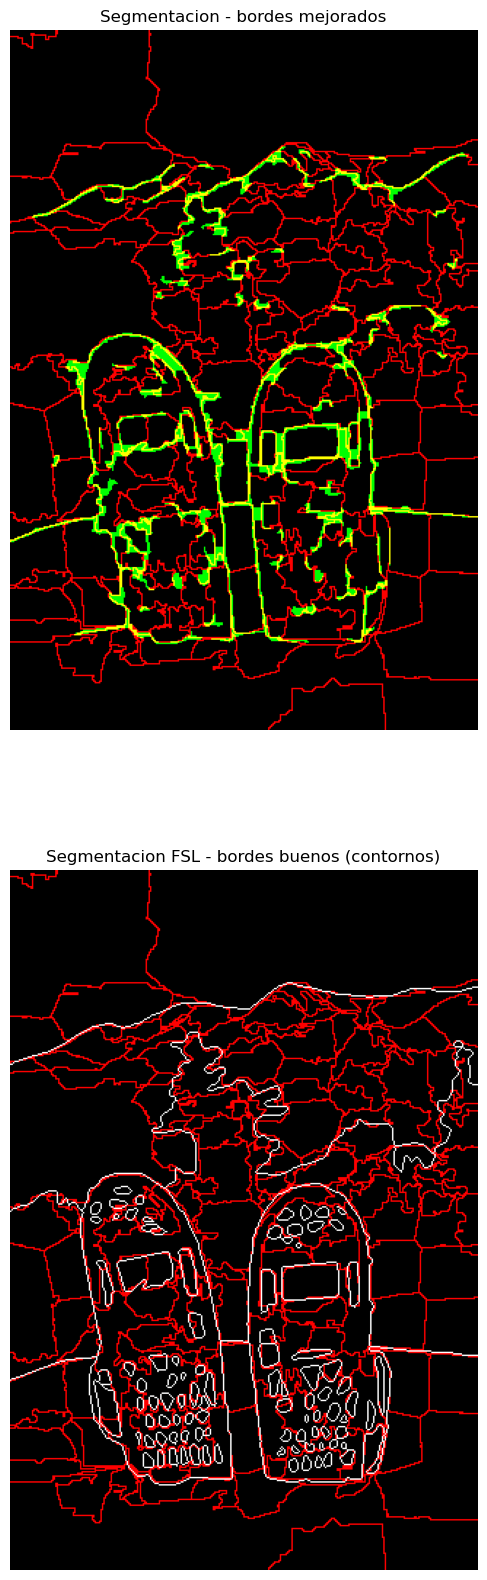

In [29]:
#ver con los bordes que hemos generado

canal1=bordes2
canal2=imagen_binarizada
canal3=bordes_image_G_S
print(np.unique(canal1),np.unique(canal2))
composicion=np.zeros((bordes2.shape[0],bordes2.shape[1],3))
composicion[:,:,0]=canal1
composicion[:,:,1]=canal2

composicion2=np.zeros((bordes2.shape[0],bordes2.shape[1],3))
composicion2[:,:,0]=canal1
composicion2[:,:,1]=canal3
composicion2[:,:,2]=canal3
composicion2[:,:,0]=np.where(canal3==1,1,composicion2[:,:,0])



plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.title('Segmentacion - bordes mejorados')
plt.imshow(composicion)
plt.axis('off')
plt.subplot(2,1,2)
plt.title(f'Segmentacion {variedad} - bordes buenos (contornos)')
plt.imshow(composicion2)
plt.axis('off')

In [30]:
#recolocamos los segmentos para que sean consecutivos
segmentacion1=reordenar(segmentacion1)


#guardamos la imagen que esamos consiguiendo en intercambio
inter="compartir"
np.save(os.path.join(inter,'segmentacion_mejoradav2'),segmentacion1)
np.save(os.path.join(inter,'bordes_segmentacion_mejoradav2'),bordes2)

In [31]:
# np.unique(segmentacion1)

## RESULTADOS

In [32]:
print("Datos FSL")
r_FSL,p_FSL=test_BR(bordes2,bordes_image_G_S)
print("segmentos:",np.max(segmentacion1))
asa_FSL=ASA(segmentacion1,image_G_S)

Datos FSL
recall: 0.8832
precision: 0.3633
segmentos: 177
aciertos:  144260 total:  154401 ASA: 0.9343


0.9343

In [ ]:
#grabamos los datos por imagen para agregarlos despues.
datos_FSL=np.array([r_FSL,p_FSL,np.max(segmentacion1),asa_FSL])

print(datos_FSL)

ruta_datos="info_imagenes_test"
np.savetxt(os.path.join(ruta_datos,"intercambio_fase4_FSL"+".csv"), datos_FSL, delimiter=',')

(-0.5, 320.5, 480.5, -0.5)

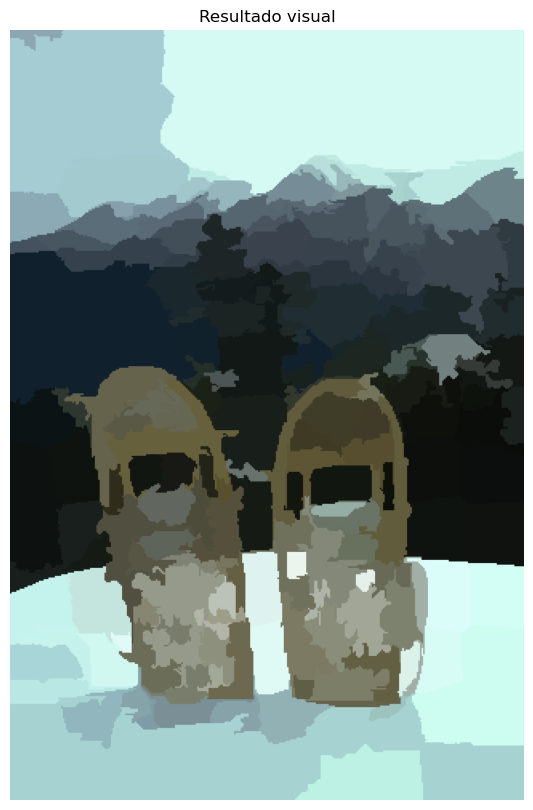

In [33]:


#para ver como de bien esta la segmentacion
from skimage.color import label2rgb
segments_visual = label2rgb(segmentacion1+1, imagen_org, kind='avg')
# segments_visual_FSL = label2rgb(n_mega+1, imagen_org, kind='avg')

plt.figure(figsize=(10, 10))

plt.title("Resultado visual")
plt.imshow(segments_visual)
plt.axis('off')